In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Mounted at /content/drive


In [42]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/DIG Historical Data 2018.csv')

# Nhận thấy tập dữ liệu, ở cột Price giá tiền có dấu phẩy và đang ở dạng string
# Bỏ dấu phẩy
df['Price'] = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df['Price'] = pd.to_numeric(df['Price'])
df = df[::-1]

In [43]:
df1=df.reset_index()['Price']
df1.head()

0    11033.2
1    11457.6
2    12094.1
3    12094.1
4    12200.2
Name: Price, dtype: float64

In [47]:
df1

0       11033.2
1       11457.6
2       12094.1
3       12094.1
4       12200.2
         ...   
1547    30450.0
1548    29900.0
1549    30400.0
1550    31700.0
1551    31950.0
Name: Price, Length: 1552, dtype: float64

In [48]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [49]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [50]:
test_size

465

In [51]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [52]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [53]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [55]:
X_train.shape

(985, 100, 1)

In [56]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [57]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 [==============================] - 2s 35ms/step - loss: 0.0032
Epoch 2/100
16/16 [==============================] - 1s 33ms/step - loss: 0.0013
Epoch 3/100
16/16 [==============================] - 1s 36ms/step - loss: 9.0012e-04
Epoch 4/100
16/16 [==============================] - 1s 37ms/step - loss: 7.8362e-04
Epoch 5/100
16/16 [==============================] - 1s 35ms/step - loss: 6.1230e-04
Epoch 6/100
16/16 [==============================] - 1s 37ms/step - loss: 5.4146e-04
Epoch 7/100
16/16 [==============================] - 0s 18ms/step - loss: 4.9538e-04
Epoch 8/100
16/16 [==============================] - 0s 18ms/step - loss: 4.7220e-04
Epoch 9/100
16/16 [==============================] - 0s 22ms/step - loss: 4.7549e-04
Epoch 10/100
16/16 [==============================] - 0s 21ms/step - loss: 4.2644e-04
Epoch 11/100
16/16 [==============================] - 0s 22ms/step - loss: 3.8924e-04
Epoch 12/100
16/16 [==============================] - 0s 19ms/step - lo

In [58]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)


12/12 [==============================] - 0s 6ms/step


In [59]:
# 11. Chuẩn hóa dữ liệu y_pred, y_test
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [60]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 1187.7535566973954


In [61]:
x_input.shape

(1, 100, 1)

In [65]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=405
i=0
while(i<30):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.37506946 0.38762337 0.36469883 0.37070288 0.37234034 0.37834439
 0.37779857 0.37343199 0.37234034 0.34450341 0.36469883 0.36033225
 0.36469883 0.36579048 0.36251554 0.34286594 0.34286594 0.339591
 0.34832416 0.32649127 0.3101166  0.33194949 0.32103305 0.31666647
 0.31666647 0.315029   0.29592522 0.28828371 0.28882953 0.28719206
 0.28992117 0.27900473 0.27627561 0.26535917 0.26426752 0.25553437
 0.25225943 0.22988072 0.2222392  0.2391597  0.22605996 0.21896427
 0.2173268  0.19713138 0.1976772  0.20422707 0.20695618 0.19549391
 0.21405187 0.21296022 0.20422707 0.18512328 0.16765697 0.1512823
 0.13599928 0.14418661 0.13545345 0.12126207 0.13436181 0.13108687
 0.12235372 0.10925398 0.09670007 0.0852378  0.07432135 0.06449655
 0.05521757 0.04648441 0.03829708 0.04593859 0.04975935 0.05794668
 0.06667984 0.06995477 0.06012997 0.06067579 0.06995477 0.07977958
 0.08960438 0.10052082 0.11252891 0.12508283 0.13872839 0.12399118
 0.11034563 0.12289954 0.13599928 0.12180789 0.129449

In [83]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size+1-101, step=1)
test_data_index.shape

(365,)

In [73]:
y_pred.shape

(365, 1)

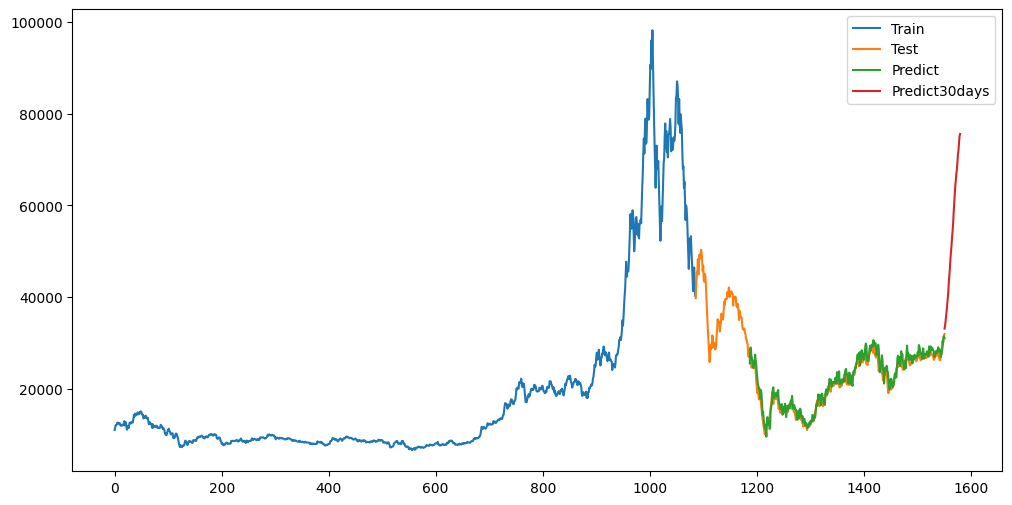

In [85]:
# 14.Vẽ hình
plt.figure(figsize=(12,6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()